# Slot Filler Analysis (simplified approach)

In [4]:
import json
import sys
import collections

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from tf.app import use

TOOLS_LIB = "/Users/cody/github/BH_time_collocations/workflow/notebooks/analysis"
sys.path.append(TOOLS_LIB)

from scripts.stats.significance import apply_deltaP
from scripts.plotting import heatmap
from scripts.paths import paths

In [2]:
bhsa = use('etcbc/bhsa', version='c')
F, E, T, L = (getattr(bhsa.api, method) for method in "FETL")

In [5]:
with open(paths['cl_clusters'], 'r') as infile:
    clclusts = json.load(infile)
    
cc10_books = list(clclusts['10']['bookbounds'].keys())
cc10_bbounds = list(clclusts['10']['bookbounds'].values())

In [30]:
clclusts['10']['clusters']['427553']

1

# Define Dataset

In [31]:
custom_sets = {}

In [32]:
# a strict search for all noun-based phrases (with or without preposition)
strict_np_phrases = bhsa.search("""

ph:phrase
/with/
    word pdp=subs
/-/
/without/
    word lex=W
/-/
/without/
    word pdp=advb
/-/
/without/
    phrase_atom rela=Link|Para
/-/
/without/
clause
-mother> ph
/-/
    =: word pdp=prep
    <: word

""")

# a strict search that excludes all other items in the phrase
strict_prep_def_appo = bhsa.search("""

phrase
    =: word pdp=prep
    <: word lex=H
    <: word
    <: word lex=H
    <: word
    :=

""")

  0.67s 33328 results
  0.87s 1338 results


In [33]:
funct_counts = collections.Counter()

for res in strict_np_phrases:
    function = F.function.v(res[0])
    if function in {'Time', 'Adju', 'Loca', 'Cmpl', 'Objc', 'Subj', 'PreC'}: 
        funct_counts[function] += 1

In [34]:
funct_counts = pd.DataFrame.from_dict(funct_counts, orient='index')

funct_counts

,0
Time,2084
PreC,3344
Cmpl,14637
Objc,4751
Adju,6590
Loca,1497
Subj,75


In [35]:
funct_counts / funct_counts.sum()

,0
Time,0.063194
PreC,0.101401
Cmpl,0.443841
Objc,0.144066
Adju,0.199830
Loca,0.045394
Subj,0.002274


In [36]:
# bhsa.show(
#     test, extraFeatures='pdp'
# )

# Build Table

In [37]:
rows = []

for result in strict_prep_def_appo:
    
    row = {}
    
    phrase = row["phrase_node"] = result[0]
    book, ch, vs = T.sectionFromNode(phrase)
    row["ref"] = f'{book} {ch}:{vs}'
    row["book"] = book
    row["phrase_text"] = T.text(phrase)
    cl_node = row["cl_node"] = L.u(phrase, 'clause')[0]
    row["cl_clust10"] = clclusts["10"]["clusters"][str(cl_node)]
    row["clause_text"] = T.text(cl_node)
    row["function"] = F.function.v(phrase)
        
    # collect slot data
    slots = [
        ("slot1", result[1]),
        ("slot2", result[3]),
        ("slot3", result[5]),
    ]
    for slotname, slot in slots:
        row[slotname] = slot
        row[f'{slotname}_lex'] = F.lex.v(slot)
        row[f'{slotname}_pos'] = F.pdp.v(slot)
        row[f'{slotname}_ls'] = F.ls.v(slot)
        
    rows.append(row)

In [38]:
len(rows)

1338

In [39]:
df = pd.DataFrame(rows)

df.head()

,phrase_node,ref,book,phrase_text,cl_node,cl_clust10,clause_text,function,slot1,slot1_lex,slot1_pos,slot1_ls,slot2,slot2_lex,slot2_pos,slot2_ls,slot3,slot3_lex,slot3_pos,slot3_ls
0,651923,Genesis 2:2,Genesis,בַּיֹּ֣ום הַשְּׁבִיעִ֔י,427680,13,וַיְכַ֤ל אֱלֹהִים֙ בַּיֹּ֣ום הַשְּׁבִיעִ֔י מְל...,Time,687,B,prep,none,689,JWM/,subs,padv,691,CBJ<J/,adjv,ordn
1,651929,Genesis 2:2,Genesis,בַּיֹּ֣ום הַשְּׁבִיעִ֔י,427682,13,וַיִּשְׁבֹּת֙ בַּיֹּ֣ום הַשְּׁבִיעִ֔י מִכָּל־מ...,Time,697,B,prep,none,699,JWM/,subs,padv,701,CBJ<J/,adjv,ordn
2,653115,Genesis 6:4,Genesis,בַּיָּמִ֣ים הָהֵם֒,428069,52,הַנְּפִלִ֞ים הָי֣וּ בָאָרֶץ֮ בַּיָּמִ֣ים הָהֵם֒,Time,2666,B,prep,none,2668,JWM/,subs,padv,2670,HM,prde,none
3,653329,Genesis 7:1,Genesis,בַּדֹּ֥ור הַזֶּֽה׃,428137,59,כִּֽי־אֹתְךָ֥ רָאִ֛יתִי צַדִּ֥יק לְפָנַ֖י בַּד...,Adju,3057,B,prep,none,3059,DWR/,subs,none,3061,ZH,prde,none
4,653402,Genesis 7:11,Genesis,בַּחֹ֨דֶשׁ֙ הַשֵּׁנִ֔י,428158,61,בִּשְׁנַ֨ת שֵׁשׁ־מֵאֹ֤ות שָׁנָה֙ לְחַיֵּי־נֹ֔ח...,Time,3236,B,prep,none,3238,XDC=/,subs,none,3240,CNJ/,adjv,ordn


In [40]:
df.slot1_lex.value_counts()

B       621
>T      257
<D       88
K        82
>L       81
L        80
<L       54
MN       32
>XR/     15
TXT/     12
BJN/      4
<M        4
B<D/      4
DRK/      2
>T==      1
>YL/      1
Name: slot1_lex, dtype: int64

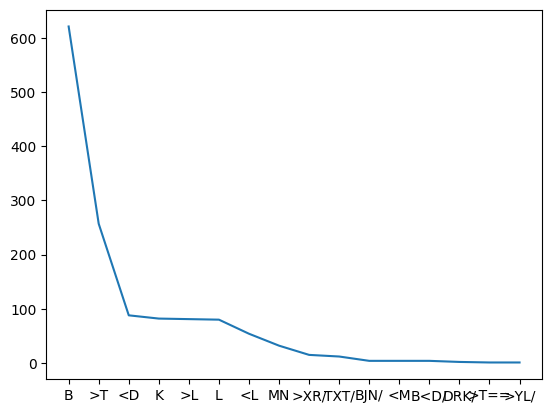

In [41]:
plt.plot(df.slot1_lex.value_counts())

# EDA for בַּיּוֹם הַהוּא

In [42]:
a1_df = df[
    (df.slot1_lex == 'B')
    & (df.slot2_lex == 'JWM/')
    & (df.slot3_lex == 'HW>')
]

# number of times it occurs
a1_df.shape

(205, 20)

In [43]:
a1_df.function.value_counts()

Time    205
Name: function, dtype: int64

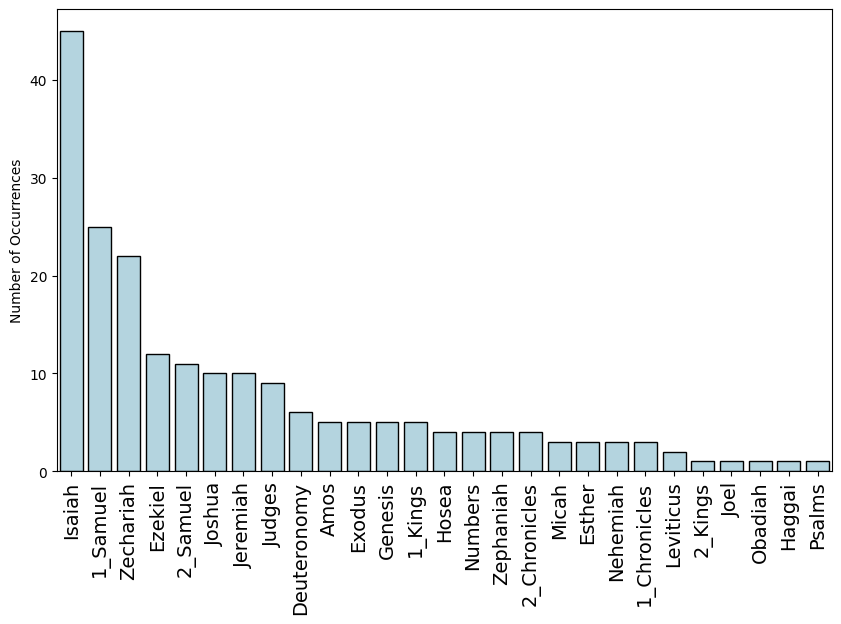

In [44]:
book_counts = a1_df.book.value_counts()

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    x=np.arange(book_counts.shape[0]),
    y=book_counts,
    color='lightblue',
    edgecolor='black',
)

ax.set_ylabel('Number of Occurrences')
xticklabels = ax.set_xticklabels(book_counts.index, rotation=90, size=14)

OUTDIR = '/Users/cody/Library/Mobile Documents/com~apple~CloudDocs/dissertation/cx_pilot_2022/result_plots'

plt.savefig(f'{OUTDIR}/book_distribution.pdf', format='pdf', bbox_inches='tight')

In [62]:
book_counts

Isaiah          45
1_Samuel        25
Zechariah       22
Ezekiel         12
2_Samuel        11
Joshua          10
Jeremiah        10
Judges           9
Deuteronomy      6
Amos             5
Exodus           5
Genesis          5
1_Kings          5
Hosea            4
Numbers          4
Zephaniah        4
2_Chronicles     4
Micah            3
Esther           3
Nehemiah         3
1_Chronicles     3
Leviticus        2
2_Kings          1
Joel             1
Obadiah          1
Haggai           1
Psalms           1
Name: book, dtype: int64

In [65]:
book_counts['1_Samuel'] + book_counts['2_Samuel']

36

In [57]:
prophets = [
    'Isaiah', 
    'Zechariah',
    'Ezekiel',
    'Jeremiah',
    'Amos',
    'Hosea',
    'Zephaniah',
    'Micah',
    'Joel',
    'Obadiah',
    'Haggai',
]

minor_prophets = [
    'Zechariah',
    'Amos',
    'Hosea',
    'Zephaniah',
    'Micah',
    'Joel',
    'Obadiah',
    'Haggai',
]

In [58]:
book_counts[book_counts.index.isin(prophets)].sum()

108

In [59]:
book_counts[book_counts.index.isin(prophets)].sum() / book_counts.sum()

0.526829268292683

In [60]:
book_counts[book_counts.index.isin(minor_prophets)].sum()

41

In [61]:
book_counts[book_counts.index.isin(minor_prophets)].sum() / book_counts.sum()

0.2

In [63]:
book_prop = book_counts / book_counts.sum()

book_prop

Isaiah          0.219512
1_Samuel        0.121951
Zechariah       0.107317
Ezekiel         0.058537
2_Samuel        0.053659
Joshua          0.048780
Jeremiah        0.048780
Judges          0.043902
Deuteronomy     0.029268
Amos            0.024390
Exodus          0.024390
Genesis         0.024390
1_Kings         0.024390
Hosea           0.019512
Numbers         0.019512
Zephaniah       0.019512
2_Chronicles    0.019512
Micah           0.014634
Esther          0.014634
Nehemiah        0.014634
1_Chronicles    0.014634
Leviticus       0.009756
2_Kings         0.004878
Joel            0.004878
Obadiah         0.004878
Haggai          0.004878
Psalms          0.004878
Name: book, dtype: float64

In [64]:
book_prop['1_Samuel'] + book_prop['2_Samuel']

0.17560975609756097

In [51]:
def plot_distrib(df, ax=None, title='', **kwargs):
    """Plot distribution plot."""
    kws = {
        's': 4,
        'color': 'darkblue',
    }
    kws.update(kwargs)
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 3))
    sns.swarmplot(x=df.cl_clust10, ax=ax, **kws)
    ax.set_xticks(cc10_bbounds)
    ax.set_xticklabels(cc10_books, rotation=60)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.grid(axis='x')
    ax.set_axisbelow(True)

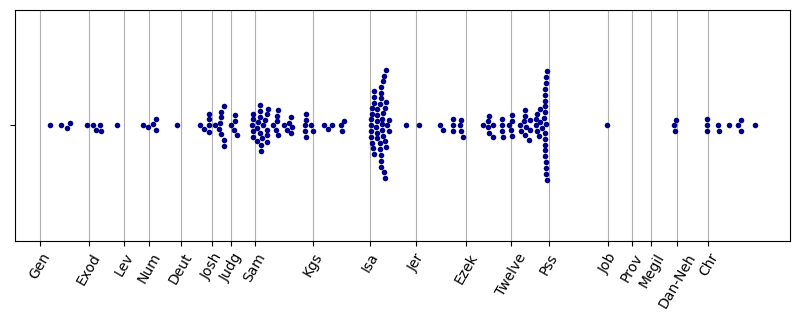

In [53]:
plot_distrib(a1_df)

plt.savefig(f'{OUTDIR}/book_distribution_swarm.pdf', format='pdf', bbox_inches='tight')

In [66]:
a1_df[a1_df.book == 'Psalms']

,phrase_node,ref,book,phrase_text,cl_node,cl_clust10,clause_text,function,slot1,slot1_lex,slot1_pos,slot1_ls,slot2,slot2_lex,slot2_pos,slot2_ls,slot3,slot3_lex,slot3_pos,slot3_ls
1180,852715,Psalms 146:4,Psalms,בַּיֹּ֥ום הַ֝ה֗וּא,497350,6978,בַּיֹּ֥ום הַ֝ה֗וּא אָבְד֥וּ עֶשְׁתֹּנֹתָֽיו׃,Time,335476,B,prep,none,335478,JWM/,subs,padv,335480,HW>,prde,none


## Book plot for PP+def_appo

(597, 19)


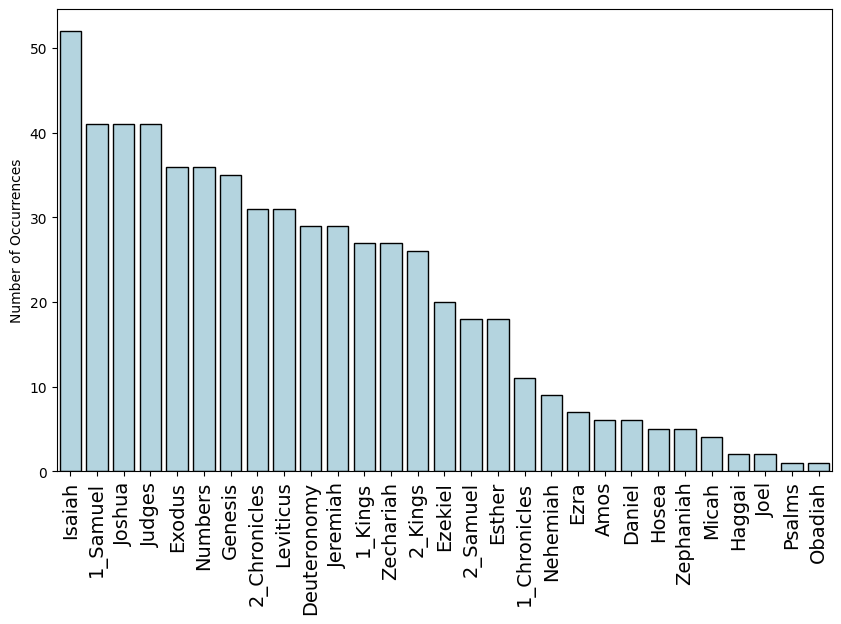

In [161]:
df2 = df[df.function == 'Time']

print(df2.shape)

book_counts = df2.book.value_counts()

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    x=np.arange(book_counts.shape[0]),
    y=book_counts,
    color='lightblue',
    edgecolor='black',
)

ax.set_ylabel('Number of Occurrences')
xticklabels = ax.set_xticklabels(book_counts.index, rotation=90, size=14)

OUTDIR = '/Users/cody/Library/Mobile Documents/com~apple~CloudDocs/dissertation/drafts/cx_pilot_2022/result_plots'

plt.savefig(f'{OUTDIR}/ALL_book_distribution.pdf', format='pdf', bbox_inches='tight')

In [151]:
import random

In [152]:
results = [(ph,) for ph in a1_df.phrase_node.values]

len(results)

205

In [153]:
a1_df

,phrase_node,ref,book,phrase_text,cl_node,clause_text,function,slot1,slot1_lex,slot1_pos,slot1_ls,slot2,slot2_lex,slot2_pos,slot2_ls,slot3,slot3_lex,slot3_pos,slot3_ls
14,655391,Genesis 15:18,Genesis,בַּיֹּ֣ום הַה֗וּא,428794,בַּיֹּ֣ום הַה֗וּא כָּרַ֧ת יְהוָ֛ה אֶת־אַבְרָ֖ם...,Time,6963,B,prep,none,6965,JWM/,subs,padv,6967,HW>,prde,none
38,659624,Genesis 26:32,Genesis,בַּיֹּ֣ום הַה֗וּא,430201,וַיְהִ֣י׀ בַּיֹּ֣ום הַה֗וּא,Time,13565,B,prep,none,13567,JWM/,subs,padv,13569,HW>,prde,none
45,661471,Genesis 30:35,Genesis,בַּיֹּום֩ הַה֨וּא,430821,וַיָּ֣סַר בַּיֹּום֩ הַה֨וּא אֶת־הַתְּיָשִׁ֜ים ...,Time,16163,B,prep,none,16165,JWM/,subs,padv,16167,HW>,prde,none
55,662865,Genesis 33:16,Genesis,בַּיֹּ֨ום הַה֥וּא,431290,וַיָּשָׁב֩ בַּיֹּ֨ום הַה֥וּא עֵשָׂ֛ו לְדַרְכֹּ...,Time,18372,B,prep,none,18374,JWM/,subs,padv,18376,HW>,prde,none
81,668856,Genesis 48:20,Genesis,בַּיֹּ֣ום הַהוּא֮,433299,וַיְבָ֨רֲכֵ֜ם בַּיֹּ֣ום הַהוּא֮,Time,27714,B,prep,none,27716,JWM/,subs,padv,27718,HW>,prde,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,894517,1_Chronicles 29:22,1_Chronicles,בַּיֹּ֥ום הַה֖וּא,512335,וַיִּשְׁתּ֜וּ לִפְנֵ֧י יְהוָ֛ה בַּיֹּ֥ום הַה֖ו...,Time,406638,B,prep,none,406640,JWM/,subs,padv,406642,HW>,prde,none
1312,898289,2_Chronicles 15:11,2_Chronicles,בַּיֹּ֣ום הַה֔וּא,513552,וַיִּזְבְּח֤וּ לַיהוָה֙ בַּיֹּ֣ום הַה֔וּא מִן־...,Time,414031,B,prep,none,414033,JWM/,subs,padv,414035,HW>,prde,none
1315,899078,2_Chronicles 18:24,2_Chronicles,בַּיֹּ֣ום הַה֑וּא,513809,הִנְּךָ֥ רֹאֶ֖ה בַּיֹּ֣ום הַה֑וּא,Time,415455,B,prep,none,415457,JWM/,subs,padv,415459,HW>,prde,none
1316,899211,2_Chronicles 18:34,2_Chronicles,בַּיֹּ֣ום הַה֔וּא,513857,וַתַּ֤עַל הַמִּלְחָמָה֙ בַּיֹּ֣ום הַה֔וּא,Time,415673,B,prep,none,415675,JWM/,subs,padv,415677,HW>,prde,none


In [156]:
book2examples = collections.defaultdict(list)

for ph_node in a1_df.phrase_node:
    book, ch, vs = T.sectionFromNode(ph_node)
    book2examples[book].append(ph_node)

In [158]:
for book, examples in book2examples.items():
    print(book)
    for ex in examples:
        vs = L.u(ex, 'verse')[0]
        book, ch, verse = T.sectionFromNode(vs)
        print(f'{ch}:{verse}')
        print(f'\t', T.text(vs))

Genesis
15:18
	 בַּיֹּ֣ום הַה֗וּא כָּרַ֧ת יְהוָ֛ה אֶת־אַבְרָ֖ם בְּרִ֣ית לֵאמֹ֑ר לְזַרְעֲךָ֗ נָתַ֨תִּי֙ אֶת־הָאָ֣רֶץ הַזֹּ֔את מִנְּהַ֣ר מִצְרַ֔יִם עַד־הַנָּהָ֥ר הַגָּדֹ֖ל נְהַר־פְּרָֽת׃ 
26:32
	 וַיְהִ֣י׀ בַּיֹּ֣ום הַה֗וּא וַיָּבֹ֨אוּ֙ עַבְדֵ֣י יִצְחָ֔ק וַיַּגִּ֣דוּ לֹ֔ו עַל־אֹדֹ֥ות הַבְּאֵ֖ר אֲשֶׁ֣ר חָפָ֑רוּ וַיֹּ֥אמְרוּ לֹ֖ו מָצָ֥אנוּ מָֽיִם׃ 
30:35
	 וַיָּ֣סַר בַּיֹּום֩ הַה֨וּא אֶת־הַתְּיָשִׁ֜ים הָֽעֲקֻדִּ֣ים וְהַטְּלֻאִ֗ים וְאֵ֤ת כָּל־הָֽעִזִּים֙ הַנְּקֻדֹּ֣ות וְהַטְּלֻאֹ֔ת כֹּ֤ל אֲשֶׁר־לָבָן֙ בֹּ֔ו וְכָל־ח֖וּם בַּכְּשָׂבִ֑ים וַיִּתֵּ֖ן בְּיַד־בָּנָֽיו׃ 
33:16
	 וַיָּשָׁב֩ בַּיֹּ֨ום הַה֥וּא עֵשָׂ֛ו לְדַרְכֹּ֖ו שֵׂעִֽירָה׃ 
48:20
	 וַיְבָ֨רֲכֵ֜ם בַּיֹּ֣ום הַהוּא֮ לֵאמֹור֒ בְּךָ֗ יְבָרֵ֤ךְ יִשְׂרָאֵל֙ לֵאמֹ֔ר יְשִֽׂמְךָ֣ אֱלֹהִ֔ים כְּאֶפְרַ֖יִם וְכִמְנַשֶּׁ֑ה וַיָּ֥שֶׂם אֶת־אֶפְרַ֖יִם לִפְנֵ֥י מְנַשֶּֽׁה׃ 
Exodus
5:6
	 וַיְצַ֥ו פַּרְעֹ֖ה בַּיֹּ֣ום הַה֑וּא אֶת־הַנֹּגְשִׂ֣ים בָּעָ֔ם וְאֶת־שֹׁטְרָ֖יו לֵאמֹֽר׃ 
8:18
	 וְהִפְלֵיתִי֩ בַיֹּ֨ום הַה֜וּא אֶת־אֶ֣רֶץ גֹּ֗שֶׁן אֲשֶׁ֤ר עַמִּי֙ עֹמֵ

In [125]:
ph_node

904335

In [123]:
for book in a1_df.book.unique():
    phs = random.sample(list(a1_df[a1_df.book == book].phrase_node), 5)
    
    print(book)

Genesis
Exodus
Leviticus
Numbers
Deuteronomy
Joshua
Judges
1_Samuel
2_Samuel
1_Kings


ValueError: Sample larger than population or is negative

In [118]:
a1_df.columns

Index(['phrase_node', 'ref', 'book', 'phrase_text', 'cl_node', 'clause_text',
       'function', 'slot1', 'slot1_lex', 'slot1_pos', 'slot1_ls', 'slot2',
       'slot2_lex', 'slot2_pos', 'slot2_ls', 'slot3', 'slot3_lex', 'slot3_pos',
       'slot3_ls'],
      dtype='object')

In [111]:
bhsa.show(
    results,
)


In [34]:
book_cphrase_node

Isaiah          45
1_Samuel        25
Zechariah       22
Ezekiel         12
2_Samuel        11
Joshua          10
Jeremiah        10
Judges           9
Deuteronomy      6
Amos             5
Exodus           5
Genesis          5
1_Kings          5
Hosea            4
Numbers          4
Zephaniah        4
2_Chronicles     4
Micah            3
Esther           3
Nehemiah         3
1_Chronicles     3
Leviticus        2
2_Kings          1
Joel             1
Obadiah          1
Haggai           1
Psalms           1
Name: book, dtype: int64

### Plural variants

In [47]:
plural_a1 = df[
    (df.slot1_lex == 'B')
    & (df.slot2_lex == 'JWM/')
    & (df.slot3_lex != 'HW>')
]

plural_a1.shape

(158, 19)

In [48]:
plural_a1

,phrase_node,ref,book,phrase_text,cl_node,clause_text,function,slot1,slot1_lex,slot1_pos,slot1_ls,slot2,slot2_lex,slot2_pos,slot2_ls,slot3,slot3_lex,slot3_pos,slot3_ls
0,651923,Genesis 2:2,Genesis,בַּיֹּ֣ום הַשְּׁבִיעִ֔י,427680,וַיְכַ֤ל אֱלֹהִים֙ בַּיֹּ֣ום הַשְּׁבִיעִ֔י מְל...,Time,687,B,prep,none,689,JWM/,subs,padv,691,CBJ<J/,adjv,ordn
1,651929,Genesis 2:2,Genesis,בַּיֹּ֣ום הַשְּׁבִיעִ֔י,427682,וַיִּשְׁבֹּת֙ בַּיֹּ֣ום הַשְּׁבִיעִ֔י מִכָּל־מ...,Time,697,B,prep,none,699,JWM/,subs,padv,701,CBJ<J/,adjv,ordn
2,653115,Genesis 6:4,Genesis,בַּיָּמִ֣ים הָהֵם֒,428069,הַנְּפִלִ֞ים הָי֣וּ בָאָרֶץ֮ בַּיָּמִ֣ים הָהֵם֒,Time,2666,B,prep,none,2668,JWM/,subs,padv,2670,HM,prde,none
5,653404,Genesis 7:11,Genesis,בַּיֹּ֣ום הַזֶּ֗ה,428158,בִּשְׁנַ֨ת שֵׁשׁ־מֵאֹ֤ות שָׁנָה֙ לְחַיֵּי־נֹ֔ח...,Time,3248,B,prep,none,3250,JWM/,subs,padv,3252,ZH,prde,none
26,657557,Genesis 22:4,Genesis,בַּיֹּ֣ום הַשְּׁלִישִׁ֗י,429501,בַּיֹּ֣ום הַשְּׁלִישִׁ֗י,Frnt,10308,B,prep,none,10310,JWM/,subs,padv,10312,CLJCJ/,adjv,ordn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,896328,2_Chronicles 7:9,2_Chronicles,בַּיֹּ֥ום הַשְּׁמִינִ֖י,512921,וַֽיַּעֲשׂ֛וּ בַּיֹּ֥ום הַשְּׁמִינִ֖י עֲצָ֑רֶת,Time,410244,B,prep,none,410246,JWM/,subs,padv,410248,CMJNJ/,adjv,ordn
1303,897225,2_Chronicles 10:12,2_Chronicles,בַּיֹּ֣ום הַשְּׁלִשִׁ֑י,513199,וַיָּבֹ֨א יָרָבְעָ֧ם וְכָל־הָעָ֛ם אֶל־רְחַבְעָ...,Time,412006,B,prep,none,412008,JWM/,subs,padv,412010,CLJCJ/,adjv,ordn
1304,897232,2_Chronicles 10:12,2_Chronicles,בַּיֹּ֥ום הַשְּׁלִשִֽׁי׃,513202,שׁ֥וּבוּ אֵלַ֖י בַּיֹּ֥ום הַשְּׁלִשִֽׁי׃,Time,412020,B,prep,none,412022,JWM/,subs,padv,412024,CLJCJ/,adjv,ordn
1318,899709,2_Chronicles 20:26,2_Chronicles,בַיֹּ֣ום הָרְבִעִ֗י,514036,וּבַיֹּ֣ום הָרְבִעִ֗י נִקְהֲלוּ֙ לְעֵ֣מֶק בְּר...,Time,416587,B,prep,none,416589,JWM/,subs,padv,416591,RBJ<J/,adjv,ordn


## Association Test 1: (time adverbial function x prep+def_appo) in HB